In [ ]:
# NOTE: please move this ipynb file out of the ats9371_for_tomography folder to use it.
from ats9371_for_tomography.ats9371 import AlazarTechATS9371
from ats9371_for_tomography.raw_acq_ctrl import RawAcquisitionController
# connect to ATS9371
ats_inst = AlazarTechATS9371(name='ATS9371')
acq_ctrl = RawAcquisitionController(
    name='ATS9371_acq', alazar_name='ATS9371'
)

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import clear_output

In [3]:
def max_record(n_samples, max_mb=84):
    max_bit = max_mb * 1024 * 1024 * 8
    resolution_bit = 12
    return int(max_bit/ resolution_bit / n_samples)
def acq_size_mb(n_records, n_samples):
    resolution_bit = 12
    return (n_records * n_samples * resolution_bit) / 1024 / 1024 / 8

In [4]:
# config setting
SAMPLING_RATE = 1_000_000_000 # 1GHz
with ats_inst.syncing():
    ats_inst.clock_source("INTERNAL_CLOCK")
    ats_inst.sample_rate(SAMPLING_RATE)
    ats_inst.trigger_operation('TRIG_ENGINE_OP_J')
    ats_inst.trigger_engine1("TRIG_ENGINE_J")
    ats_inst.trigger_source1("EXTERNAL")
    ats_inst.trigger_slope1("TRIG_SLOPE_POSITIVE")
    ats_inst.trigger_level1(160)
    ats_inst.trigger_delay(1400) # samples
    ats_inst.trigger_source2("DISABLE")
# acquisition setting
NUMBER_OF_RECORDS = 8192 # trace per acquisition, max 84MB
NUMBER_OF_SAMPLES = 3200 # samples per trace
acq_ctrl.update_acquisitionkwargs(
    samples_per_record = NUMBER_OF_SAMPLES,
    records_per_buffer = NUMBER_OF_RECORDS,
    buffers_per_acquisition = 1,
    allocated_buffers = 1,
)

(8192, 3200)


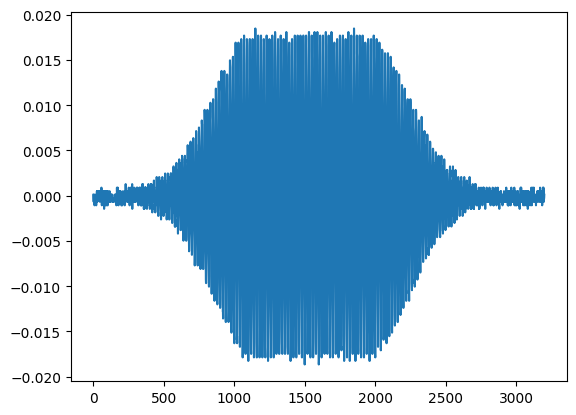

In [5]:
# test acquisition
acq_ctrl.do_acquisition()
chaA, chaB = acq_ctrl.numpy_get_alldata_from_buffer_in_volt()
print(chaA.shape)
plt.plot(chaA[0])
plt.show()

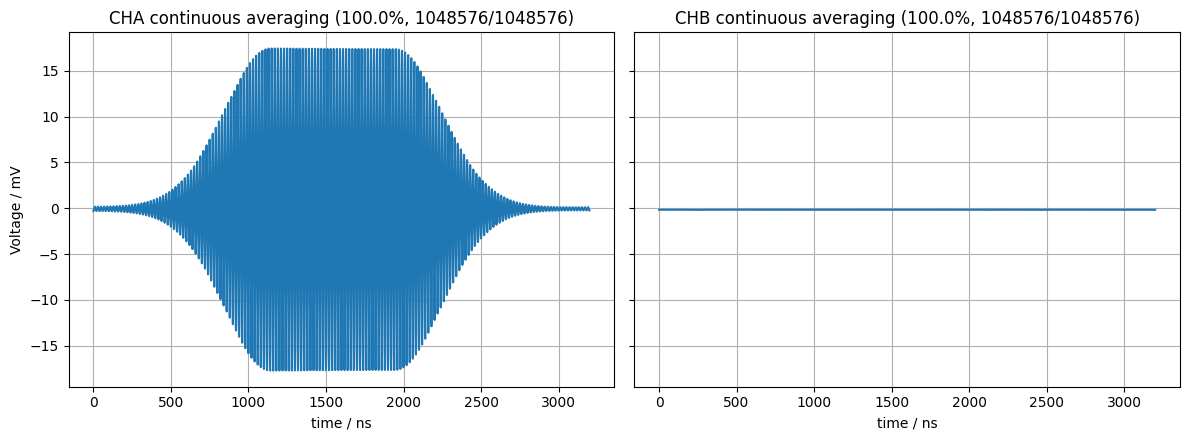

In [6]:
## example - continous avg measurement

# acquisition setting
n_shots = 2**20
batch_size = NUMBER_OF_RECORDS
n_batches = n_shots // batch_size
update_interval = n_batches // 16

# initialize processing utils
chaA_mean = np.zeros(NUMBER_OF_SAMPLES)
chaB_mean = np.zeros(NUMBER_OF_SAMPLES)
time_arr = np.arange(NUMBER_OF_SAMPLES) / SAMPLING_RATE

# start measurement
for n in range(n_batches):
    # aqusition
    acq_ctrl.do_acquisition()
    chaA, chaB = acq_ctrl.numba_get_alldata_from_buffer_in_volt(copy=False)

    # continous averaging
    chaA_mean = (chaA_mean*n + np.mean(chaA, axis=0)) / (n + 1)
    chaB_mean = (chaB_mean*n + np.mean(chaB, axis=0)) / (n + 1)

    # plotting
    if (n + 1) % update_interval == 0:
        clear_output(wait=True)
        fig, ax = plt.subplots(1, 2, figsize=(12, 4.5), sharey=True)  # 1 row, 2 columns
        ax[0].plot(1e9*time_arr, 1000*chaA_mean)
        ax[0].set_title(f'CHA continuous averaging ({(n + 1)/n_batches* 100:.1f}%, {batch_size*(n + 1)}/{n_shots})')
        ax[0].set_ylabel('Voltage / mV')
        ax[0].set_xlabel('time / ns')
        ax[0].grid(True)

        ax[1].plot(1e9*time_arr, 1000*chaB_mean)
        ax[1].set_title(f'CHB continuous averaging ({(n + 1)/n_batches* 100:.1f}%, {batch_size*(n + 1)}/{n_shots})')
        ax[1].set_xlabel('time / ns')
        ax[1].grid(True)
        plt.tight_layout()
        plt.show()

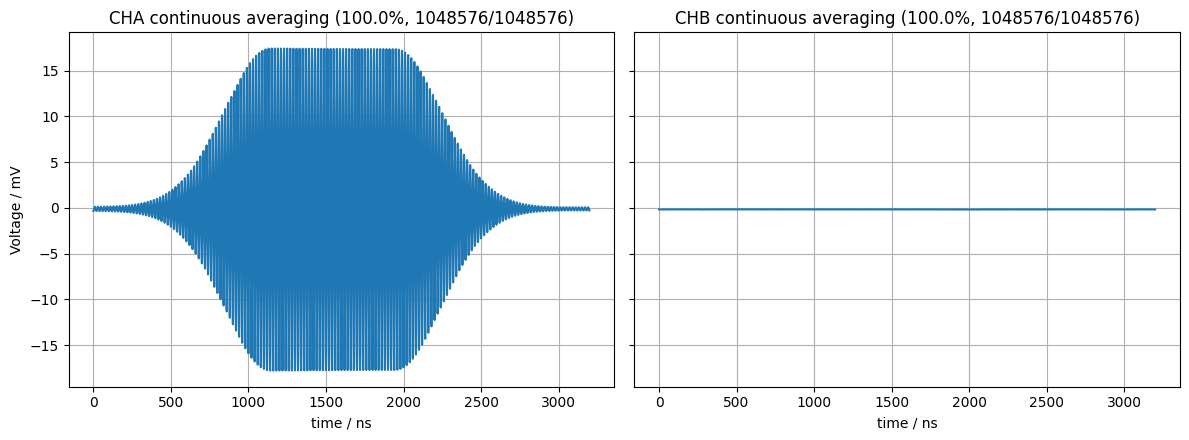

In [7]:
## example - measurement with thred
from threading import Thread

# acquisition setting
n_shots = 2**20
batch_size = NUMBER_OF_RECORDS
n_batches = n_shots // batch_size
update_interval = n_batches // 16

# initialize processing utils
chaA_mean = np.zeros(NUMBER_OF_SAMPLES)
chaB_mean = np.zeros(NUMBER_OF_SAMPLES)
time_arr = np.arange(NUMBER_OF_SAMPLES) / SAMPLING_RATE
def process(n):
    # now use channel B (noise) for tomography
    global chaA_mean, chaB_mean, chaA_acq, chaB_acq
    chaA_mean = (chaA_mean*n + np.mean(chaA_acq, axis=0)) / (n + 1)
    chaB_mean = (chaB_mean*n + np.mean(chaB_acq, axis=0)) / (n + 1)

# first batch aqusition
acq_ctrl.do_acquisition()
chaA_acq, chaB_acq = acq_ctrl.numba_get_alldata_from_buffer_in_volt(copy=False)
for n in range(1, n_batches):
    # start processing of [batch N]
    process_thread = Thread(target=process, args=(n-1,))
    process_thread.start()
    # aquire [batch N+1] into buffer while processing [batch N]
    acq_ctrl.do_acquisition()
    # wait for [batch N] processing to finish before read [batch N+1] from buffer
    process_thread.join()
    chaA_acq, chaB_acq = acq_ctrl.numba_get_alldata_from_buffer_in_volt(copy=False)

    # plotting
    if (n + 1) % update_interval == 0:
        clear_output(wait=True)
        fig, ax = plt.subplots(1, 2, figsize=(12, 4.5), sharey=True)  # 1 row, 2 columns
        ax[0].plot(1e9*time_arr, 1000*chaA_mean)
        ax[0].set_title(f'CHA continuous averaging ({(n + 1)/n_batches* 100:.1f}%, {batch_size*(n + 1)}/{n_shots})')
        ax[0].set_ylabel('Voltage / mV')
        ax[0].set_xlabel('time / ns')
        ax[0].grid(True)

        ax[1].plot(1e9*time_arr, 1000*chaB_mean)
        ax[1].set_title(f'CHB continuous averaging ({(n + 1)/n_batches* 100:.1f}%, {batch_size*(n + 1)}/{n_shots})')
        ax[1].set_xlabel('time / ns')
        ax[1].grid(True)
        plt.tight_layout()
        plt.show()